##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import TweetTokenizer
from bs4 import BeautifulSoup
import re
import unidecode
from string import punctuation
import contractions
from tabulate import tabulate
import collections

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lingpeng\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lingpeng\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Lingpeng\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:

#Read the CSV datafiles (Train and Test).
train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')


Then we separate the tweet text and the label (sentiment). 

In [7]:
#separating instance and label for Train
X_train_raw = [x[0] for x in train_data[['text']].values]
Y_train = [x[0] for x in train_data[['sentiment']].values]

#check the result
print("Train length:",len(X_train_raw))

#separating instance and label for Test
X_test_raw = [x[0] for x in test_data[['text']].values]

#check the result
print("Test length:",len(X_test_raw))

Train length: 21802
Test length: 6099


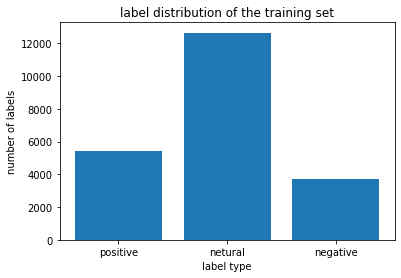

In [106]:

counter = dict(collections.Counter(Y_train))
label = ['positive','netural','negative']
data = [counter['positive'],counter['neutral'],counter['negative']]
plt.bar(label, data)
plt.title('label distribution of the training set')
plt.xlabel('label type')
plt.ylabel('number of labels')
plt.show()

In [8]:
#Split data
X_train,X_valid,y_train,y_valid = train_test_split(X_train_raw,Y_train,test_size=0.28, random_state=30027)

In [9]:
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True) 
ps = nltk.PorterStemmer()
wordnet = nltk.WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words('english')
stopwords = []
# exclude words from stopwords list
for i in stop_words:
    if i != 'not' and i != 'no':
        stopwords.append(i)
    

In [10]:
def remove_links(text):
    return re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

def remove_email(text):
    return re.sub(r'[\.a-zA-Z0-9_-]*@[\.a-zA-Z0-9_-]*', '', text)


def remove_accented_chars(text):

    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text
def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    return text
def remove_num(text):
    return ''.join([i for i in text if not i.isdigit()])
def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text
def remove_stopwords(text):
    return ' '.join([wordnet.lemmatize(i) for i in text.split() if i not in stopwords])

def remove_punc(text):
    return ''.join([i.casefold() for i in text if i not in punctuation])

def remove_num(text):
    return ''.join([i for i in text if not i.isdigit()])

def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())


#  ps.stem(word)

def remove_not_alpha(text):
    return re.sub(r'[^\s\.a-zA-Z0-9_-]+', '', text)

def preprocess(text):
    
#     text = text.replace(r'\n','').replace(r'\m','').replace(r'\r','').replace(r'\t','') 
    no_email = remove_email(text)
    no_accented_chars = remove_accented_chars(no_email)
    no_links = remove_links(no_accented_chars) 
    no_white_space = remove_whitespace(no_links)
    no_punc = remove_punc(no_white_space)  
    no_contractions = expand_contractions(no_punc)
    no_html_tags = strip_html_tags(no_contractions)
    no_num = remove_num(no_html_tags)
    no_stopwords = remove_stopwords(no_num)
    no_alpha = remove_not_alpha(no_stopwords)
    tok = tknzr.tokenize(no_alpha)
    return " ".join([ps.stem(word) for word in tok])

def prepare(text): 
    res = []
    for line in text:
        line = preprocess(line) 
        res.append(line)    
    return res    
X_train_clean = prepare(X_train)
X_valid_clean = prepare(X_valid) 


### Preprocessing: Vectorization
**Bag of Words (BoW)**

In this approach, we use the **CountVectorizer** library to separate all the words in the Train corpus (dataset). These words are then used as the 'vectors' or 'features' to represent each instance (Tweet) in `Train` and `Test` datasets. 

In [11]:


BoW_vectorizer_12 = CountVectorizer(ngram_range=(1,2))
#Build the feature set (vocabulary) and vectorise the Tarin dataset using BoW
X_train_BoW_12 = BoW_vectorizer_12.fit_transform(X_train_clean)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_valid_BoW_12 = BoW_vectorizer_12.transform(X_valid_clean)


**TFIDF**

In this approach, we use the **TfidfVectorizer** library to separate all the words in this corpus (dataset). Same as the BoW approach, these words are then used as the 'vectors' or 'features' to represent each instance (Tweet).

However, in this method for each instance the value associated with each 'vector' (word) is not the number of times the word repeated in that tweet, but the TFIDF value of then 'voctor' (word).

In [12]:


tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

#Build the feature set (vocabulary) and vectorise the Tarin dataset using TFIDF
X_train_tfidf_12 = tfidf_vectorizer.fit_transform(X_train_clean)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_valid_tfidf_12 = tfidf_vectorizer.transform(X_valid_clean)


### Preprocessing: feature selection 
**select kbest + chi2** 

In [13]:


def chi(k_value):
    selector = SelectKBest(chi2,k=k_value)
    x_train_chi_12 = selector.fit_transform(X_train_BoW_12 ,y_train)
    x_test_chi_12 = selector.transform(X_valid_BoW_12)

    return x_train_chi_12, x_test_chi_12



### Compare BoW and TFIDF


In [14]:

def chi_Tfidf(k_value, X_train_tfidf,X_valid_tfidf):
    selector = SelectKBest(chi2,k=k_value)
    x_train_chi_Tfidf = selector.fit_transform(X_train_tfidf ,y_train)
    x_test_chi_Tfidf = selector.transform(X_valid_tfidf)

    return x_train_chi_Tfidf , x_test_chi_Tfidf
    
def chi_BoW(k_value, X_train_BoW,X_valid_BoW ):
    selector = SelectKBest(chi2,k=k_value)
    x_train_chi_Bow = selector.fit_transform(X_train_BoW ,y_train)
    x_test_chi_Bow = selector.transform(X_valid_BoW)

    return x_train_chi_Bow, x_test_chi_Bow


In [15]:
#TFidf vs BoW
LR_BoW = []
LR_tfidf = []
SVM_BoW = []
SVM_tfidf = []
NB_BoW = []
NB_tfidf = []
for k in range(200,3000,200):
    x_train_chi_Bow, x_test_chi_Bow = chi_BoW(k, X_train_BoW_12, X_valid_BoW_12)
    x_train_chi_Tfidf , x_test_chi_Tfidf = chi_Tfidf(k, X_train_tfidf_12,X_valid_tfidf_12)
    lr1 = LogisticRegression(max_iter=2000).fit(x_train_chi_Bow, y_train)
    LR1_acc = np.mean(cross_val_score(lr1,x_test_chi_Bow,y_valid,cv = 5))
    LR_BoW.append(LR1_acc)
    lr2 = LogisticRegression(max_iter=2000).fit(x_train_chi_Tfidf, y_train)
    LR2_acc = np.mean(cross_val_score(lr2,x_test_chi_Tfidf,y_valid,cv = 5))
    LR_tfidf.append(LR2_acc)
    clf1 = SVC().fit(x_train_chi_Bow, y_train)
    clf1_acc = np.mean(cross_val_score(clf1,x_test_chi_Bow,y_valid,cv = 5))
    SVM_BoW.append(clf1_acc)
    clf2 = SVC().fit(x_train_chi_Tfidf, y_train)
    clf2_acc = np.mean(cross_val_score(clf2,x_test_chi_Tfidf,y_valid,cv = 5))
    SVM_tfidf.append(clf2_acc)
    nb1 = MultinomialNB().fit(x_train_chi_Bow, y_train)
    nb1_acc = np.mean(cross_val_score(nb1,x_test_chi_Bow,y_valid,cv = 5))
    NB_BoW.append(nb1_acc)
    nb2 = MultinomialNB().fit(x_train_chi_Tfidf, y_train)
    nb2_acc = np.mean(cross_val_score(nb2,x_test_chi_Tfidf,y_valid,cv = 5))
    NB_tfidf.append(nb2_acc)

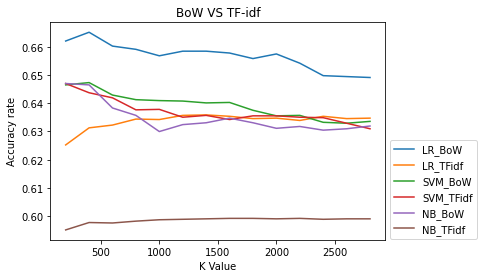

In [21]:
x = np.arange(200,3000,200)
y1 = np.array(LR_BoW )
y2 = np.array(LR_tfidf)
y3 = np.array(SVM_BoW )
y4 = np.array(SVM_tfidf)
y5 = np.array(NB_BoW )
y6 = np.array(NB_tfidf)
plt.plot(x, y1) 
plt.plot(x, y2)
plt.plot(x, y3)
plt.plot(x, y4) 
plt.plot(x, y5)
plt.plot(x, y6)
plt.xlabel("K Value") 
plt.ylabel("Accuracy rate") 
plt.title('BoW VS TF-idf')
plt.legend(['LR_BoW','LR_TFidf', 'SVM_BoW', 'SVM_TFidf', 'NB_BoW', 'NB_TFidf'],bbox_to_anchor=(1, 0.48))

**By obsverving the plots, K = 400 and BoW has the best perfermence.**

### Model: Logistic Regression
 

In [95]:

#Set K = 400
x_train_chi_LR, x_test_chi_LR = chi(400)

def gs_LogisticRegression(x_train):
    parameters_LR = {'solver':('newton-cg','lbfgs','sag','saga'),'C':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],'multi_class':('auto','ovr','multinomial')}
    LR = LogisticRegression(max_iter=2000)
    gs = GridSearchCV(LR,parameters_LR)
    gs.fit(x_train,y_train)

    return gs.best_estimator_, gs.best_score_


best_estimator_LR, best_score_LR = gs_LogisticRegression(x_train_chi_LR)


In [30]:
print(f"The best estimators area: {best_estimator_LR}")
print(f"The best score is: {best_score_LR}")

The best estimators area: LogisticRegression(C=1, max_iter=2000, solver='saga')
The best score is: 0.6746513859945661


In [42]:
#C, solver, multi_class, penalty, max_iter
def logistic_regression(k_value, c_value):
    
    x_train_chi_final_LR, x_test_chi_final_LR = chi(k_value)
    #newton-cg's acc is as same as other solvers, e.g. saga
    LR = LogisticRegression(solver= 'newton-cg', C = c_value, max_iter = 2000).fit(x_train_chi_final_LR, y_train)
    y_train_predicted = LR.predict(x_train_chi_final_LR)
    #print("training accuracy ", np.mean(y_train_predicted == y_train))
    LR_acc = np.mean(cross_val_score(LR,x_test_chi_final_LR,y_valid,cv = 5))
    #print('validation accuracy: ' ,LR_acc)
    # y_predicted = LR.predict(x_test_chi)
    #print('prediction accuracy: ',LR.score(x_test_chi_final, y_valid))

    return np.mean(y_train_predicted == y_train), LR_acc, LR.score(x_test_chi_final_LR, y_valid)

#ta_LR, va_LR, pa_LR = logistic_regression(400, 1)

**By observing the plots, K = 400**

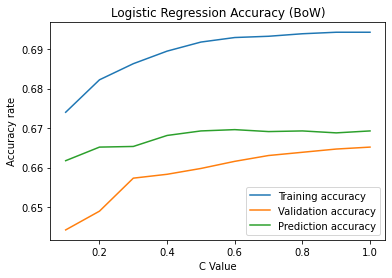

In [43]:
#Accuracy when K = 400
training_accuracy_list_LR = []
validation_accuracy_list_LR = []
prediction_accuracy_list_LR = []


for i in range(1,11,1):
    ta, va, pa = logistic_regression(400, i/10)
    training_accuracy_list_LR.append(ta)
    validation_accuracy_list_LR.append(va)
    prediction_accuracy_list_LR.append(pa)

x = np.arange(0.1,1.1,0.1) 
y1 = np.array(training_accuracy_list_LR)
y2 = np.array(validation_accuracy_list_LR)
y3 = np.array(prediction_accuracy_list_LR)
# PLot
plt.plot(x, y1) 
plt.plot(x, y2)
plt.plot(x, y3)
# Add Title
plt.title("Logistic Regression Accuracy (BoW)") 

# Add Axes Labels and legend
plt.xlabel("C Value") 
plt.ylabel("Accuracy rate") 
plt.legend(['Training accuracy','Validation accuracy', 'Prediction accuracy'])
# Display
plt.show()

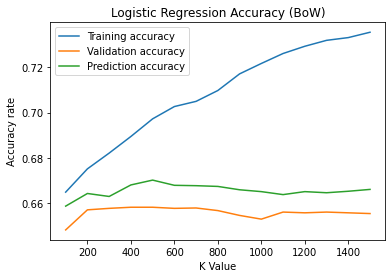

In [44]:
#Accuracy when c = 0.4
training_accuracy_list_LR = []
validation_accuracy_list_LR = []
prediction_accuracy_list_LR = []


for i in range(100,1600,100):
    ta, va, pa = logistic_regression(i,0.4)
    training_accuracy_list_LR.append(ta)
    validation_accuracy_list_LR.append(va)
    prediction_accuracy_list_LR.append(pa)

x = np.arange(100,1600,100) 
y1 = np.array(training_accuracy_list_LR)
y2 = np.array(validation_accuracy_list_LR)
y3 = np.array(prediction_accuracy_list_LR)
# PLot
plt.plot(x, y1) 
plt.plot(x, y2)
plt.plot(x, y3)
# Add Title
plt.title("Logistic Regression Accuracy (BoW)") 

# Add Axes Labels and legend
plt.xlabel("K Value") 
plt.ylabel("Accuracy rate") 
plt.legend(['Training accuracy','Validation accuracy', 'Prediction accuracy'])
# Display
plt.show()

Excution time of logtistic regression classifier: 0.127 s
training accuracy  0.6901318723322928
validation accuracy:  0.658968058968059
prediction accuracy:  0.6684684684684684
Macro Precision: 0.654097 
Macro Recall: 0.530436 
Macro F1 score: 0.558428 
Weighted Precision: 0.664786 
Weighted Recall: 0.668468 
Weighted F1 score: 0.640679 


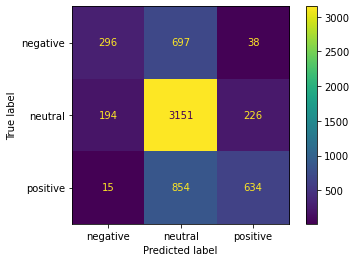

In [120]:
#Finla model: K = 400, c = 0.4
#x_train_chi_final_LR, x_test_chi_final_LR = chi(400)
t0 = time.time()
LR_final = LogisticRegression(solver= 'saga', C = 0.4, max_iter = 2000).fit(x_train_chi_LR, y_train)
t1 = time.time()-t0
print("Excution time of logtistic regression classifier: {} s". format(round(t1,3)))


y_train_predicted = LR_final.predict(x_train_chi_LR)
print("training accuracy ", np.mean(y_train_predicted == y_train))
LR_final_acc = np.mean(cross_val_score(LR_final,x_test_chi_LR,y_valid,cv = 5))
print('validation accuracy: ' ,LR_final_acc)
y_predicted = LR_final.predict(x_test_chi_LR)
print('prediction accuracy: ',LR_final.score(x_test_chi_LR, y_valid))

y_pred = LR_final.predict(x_test_chi_LR)
M_precision_LR = precision_score(y_valid, y_pred, average="macro")
print('Macro Precision: %f ' % M_precision_LR)
M_recall_LR = recall_score(y_valid, y_pred, average="macro")
print('Macro Recall: %f ' % M_recall_LR)
M_f1_LR = f1_score(y_valid, y_pred, average="macro")
print('Macro F1 score: %f ' % M_f1_LR)

W_precision_LR = precision_score(y_valid, y_pred, average="weighted")
print('Weighted Precision: %f ' % W_precision_LR)
W_recall_LR = recall_score(y_valid, y_pred, average="weighted")
print('Weighted Recall: %f ' % W_recall_LR)
W_f1_LR = f1_score(y_valid, y_pred, average="weighted")
print('Weighted F1 score: %f ' % W_f1_LR)
cm = confusion_matrix(y_valid, y_pred, labels =LR_final.classes_)
disp =ConfusionMatrixDisplay(confusion_matrix = cm, display_labels =LR_final.classes_ )
disp.plot()


### Model: SVM



In [140]:
x_train_chi_SVM, x_test_chi_SVM = chi(400)
parameters_svc = {"kernel":('linear', 'poly', 'rbf', 'sigmoid'), "decision_function_shape":('ovo','ovr')}
gs_svc = GridSearchCV(SVC(), param_grid = parameters_svc)  
gs_svc.fit(x_train_chi_SVM, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'decision_function_shape': ('ovo', 'ovr'),
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')})

In [54]:
print(gs_svc.best_params_)

{'decision_function_shape': 'ovo', 'kernel': 'linear'}


In [59]:
#C, kernel, degree, gamma, max_iter, decision_function_shape
def svc(c_value):
    clf = SVC(kernel="linear", C = c_value, decision_function_shape = 'ovo').fit(x_train_chi_SVM, y_train)
    y_train_predicted = clf.predict(x_train_chi_SVM)
    #print("training accuracy ", np.mean(y_train_predicted == y_train))
    clf_va = np.mean(cross_val_score(clf,x_test_chi_SVM,y_valid,cv = 5))
    #print('validation accuracy: ' ,clf_va)
    # y_predicted = LR.predict(x_test_chi)
    #print('prediction accuracy: ',clf.score(x_test_chi_SVM, y_valid))

    return np.mean(y_train_predicted == y_train), clf_va, clf.score(x_test_chi_SVM, y_valid)

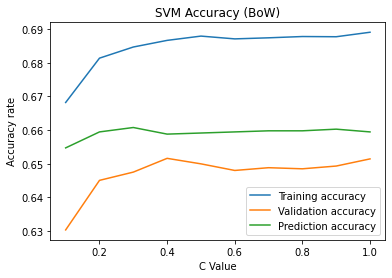

In [60]:
#Accuracy when K = 400
training_accuracy_list_SVM = []
validation_accuracy_list_SVM = []
prediction_accuracy_list_SVM = []


for i in range(1,11,1):
    ta, va, pa = svc(i/10)
    training_accuracy_list_SVM.append(ta)
    validation_accuracy_list_SVM.append(va)
    prediction_accuracy_list_SVM.append(pa)

x = np.arange(0.1,1.1,0.1) 
y1 = np.array(training_accuracy_list_SVM)
y2 = np.array(validation_accuracy_list_SVM)
y3 = np.array(prediction_accuracy_list_SVM)
# PLot
plt.plot(x, y1) 
plt.plot(x, y2)
plt.plot(x, y3)
# Add Title
plt.title("SVM Accuracy (BoW)") 

# Add Axes Labels and legend
plt.xlabel("C Value") 
plt.ylabel("Accuracy rate") 
plt.legend(['Training accuracy','Validation accuracy', 'Prediction accuracy'])
# Display
plt.show()

Excution time of logtistic regression classifier: 5.471 s
training accuracy  0.6866917245333504
validation accuracy:  0.6515970515970517
prediction accuracy:  0.6588042588042589
Macro Precision: 0.627407 
Macro Recall: 0.523475 
Macro F1 score: 0.548211 
Weighted Precision: 0.649630 
Weighted Recall: 0.658804 
Weighted F1 score: 0.632546 


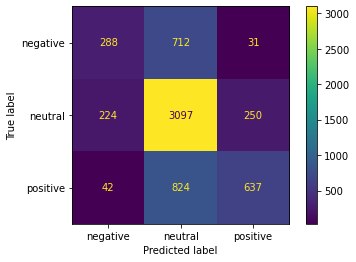

In [141]:
t0 = time.time()
SVM_final = SVC(kernel="linear", C = 0.4, decision_function_shape = 'ovo').fit(x_train_chi_SVM, y_train)
t1 = time.time()-t0
print("Excution time of logtistic regression classifier: {} s". format(round(t1,3)))

y_train_predicted = SVM_final.predict(x_train_chi_SVM)
print("training accuracy ", np.mean(y_train_predicted == y_train))
SVM_final_acc = np.mean(cross_val_score(SVM_final,x_test_chi_SVM,y_valid,cv = 5))
print('validation accuracy: ' ,SVM_final_acc)
y_predicted = SVM_final.predict(x_test_chi_SVM)
print('prediction accuracy: ',SVM_final.score(x_test_chi_SVM, y_valid))

y_pred_SVM = SVM_final.predict(x_test_chi_SVM)
M_precision_SVM = precision_score(y_valid, y_pred_SVM, average="macro")
print('Macro Precision: %f ' % M_precision_SVM)
M_recall_SVM = recall_score(y_valid, y_pred_SVM, average="macro")
print('Macro Recall: %f ' % M_recall_SVM)
M_f1_SVM = f1_score(y_valid, y_pred_SVM, average="macro")
print('Macro F1 score: %f ' % M_f1_SVM)

W_precision_SVM = precision_score(y_valid, y_pred_SVM, average="weighted")
print('Weighted Precision: %f ' % W_precision_SVM)
W_recall_SVM = recall_score(y_valid, y_pred_SVM, average="weighted")
print('Weighted Recall: %f ' % W_recall_SVM)
W_f1_SVM = f1_score(y_valid, y_pred_SVM, average="weighted")
print('Weighted F1 score: %f ' % W_f1_SVM)

cm = confusion_matrix(y_valid, y_pred_SVM, labels = SVM_final.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = SVM_final.classes_ )
disp.plot()

### Model: Multi-nominal Naive Bayes

In [68]:
x_train_chi_MNB, x_test_chi_MNB = chi(400)
parameters_MNB = {"alpha":np.linspace(0.0001,0.1,200)}
gs_MNB = GridSearchCV(MultinomialNB(), param_grid = parameters_MNB)  
gs_MNB.fit(x_train_chi_MNB, y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': array([0.0001    , 0.00060201, 0.00110402, 0.00160603, 0.00210804,
       0.00261005, 0.00311206, 0.00361407, 0.00411608, 0.00461809,
       0.0051201 , 0.00562211, 0.00612412, 0.00662613, 0.00712814,
       0.00763015, 0.00813216, 0.00863417, 0.00913618, 0.00963819,
       0.0101402 , 0.01064221, 0.01114422, 0.01164623, 0.01214824,
       0.01265025, 0.01...
       0.08293166, 0.08343367, 0.08393568, 0.08443769, 0.0849397 ,
       0.08544171, 0.08594372, 0.08644573, 0.08694774, 0.08744975,
       0.08795176, 0.08845377, 0.08895578, 0.08945779, 0.0899598 ,
       0.09046181, 0.09096382, 0.09146583, 0.09196784, 0.09246985,
       0.09297186, 0.09347387, 0.09397588, 0.09447789, 0.0949799 ,
       0.09548191, 0.09598392, 0.09648593, 0.09698794, 0.09748995,
       0.09799196, 0.09849397, 0.09899598, 0.09949799, 0.1       ])})

In [83]:
gs_MNB.best_estimator_

MultinomialNB(alpha=0.024698492462311556)

Excution time of logtistic regression classifier: 0.013 s
training accuracy  0.6710199401159457
validation accuracy:  0.6420966420966421
prediction accuracy:  0.6507780507780507
Macro Precision: 0.611245 
Macro Recall: 0.566472 
Macro F1 score: 0.582301 
Weighted Precision: 0.644567 
Weighted Recall: 0.650778 
Weighted F1 score: 0.641758 


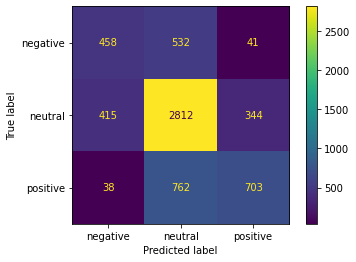

In [139]:
t0 = time.time()
MNB_final = MultinomialNB(alpha = 0.024698492462311556).fit(x_train_chi_MNB, y_train)
t1 = time.time()-t0
print("Excution time of logtistic regression classifier: {} s". format(round(t1,3)))

y_train_predicted = MNB_final.predict(x_train_chi_MNB)
print("training accuracy ", np.mean(y_train_predicted == y_train))
MNB_final_acc = np.mean(cross_val_score(MNB_final,x_test_chi_MNB,y_valid,cv = 5))
print('validation accuracy: ' ,MNB_final_acc)
y_predicted = MNB_final.predict(x_test_chi_MNB)
print('prediction accuracy: ',MNB_final.score(x_test_chi_MNB, y_valid))

y_pred_MNB = MNB_final.predict(x_test_chi_MNB)
M_precision_MNB = precision_score(y_valid, y_pred_MNB, average="macro")
print('Macro Precision: %f ' % M_precision_MNB)
M_recall_MNB = recall_score(y_valid, y_pred_MNB, average="macro")
print('Macro Recall: %f ' % M_recall_MNB)
M_f1_MNB = f1_score(y_valid, y_pred_MNB, average="macro")
print('Macro F1 score: %f ' % M_f1_MNB)

W_precision_MNB = precision_score(y_valid, y_pred_MNB, average="weighted")
print('Weighted Precision: %f ' % W_precision_MNB)
W_recall_MNB = recall_score(y_valid, y_pred_MNB, average="weighted")
print('Weighted Recall: %f ' % W_recall_MNB)
W_f1_MNB = f1_score(y_valid, y_pred_MNB, average="weighted")
print('Weighted F1 score: %f ' % W_f1_MNB)

cm = confusion_matrix(y_valid, y_pred_MNB, labels = MNB_final.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = MNB_final.classes_ )
disp.plot()

### Model: Random Forest

In [107]:
x_train_chi_RF, x_test_chi_RF = chi(400)
parameters_RF = {"n_estimators":[100,200,300,400], "criterion": ('gini', 'entropy'), "max_depth":[40,50,60,70], "min_samples_split":[2,4,6], "min_samples_leaf":[1,3,5]}
gs_RF = GridSearchCV(RandomForestClassifier(), param_grid = parameters_RF)  
gs_RF.fit(x_train_chi_RF, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [40, 50, 60, 70],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 200, 300, 400]})

In [108]:
gs_RF.best_estimator_

RandomForestClassifier(max_depth=70, min_samples_leaf=3, n_estimators=300)

Excution time of logtistic regression classifier: 2.062 s
training accuracy  0.6979677645409951
validation accuracy:  0.658968058968059
prediction accuracy:  0.6555282555282556
Macro Precision: 0.639656 
Macro Recall: 0.497219 
Macro F1 score: 0.517238 
Weighted Precision: 0.649497 
Weighted Recall: 0.655528 
Weighted F1 score: 0.616452 


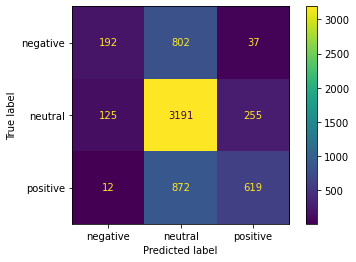

In [137]:
t0 = time.time()
RF_final = RandomForestClassifier(max_depth=70, min_samples_leaf=2, n_estimators=250).fit(x_train_chi_RF, y_train)
t1 = time.time()-t0
print("Excution time of logtistic regression classifier: {} s". format(round(t1,3)))


y_train_predicted = RF_final.predict(x_train_chi_LR)
print("training accuracy ", np.mean(y_train_predicted == y_train))
RF_final_acc = np.mean(cross_val_score(LR_final,x_test_chi_LR,y_valid,cv = 5))
print('validation accuracy: ' ,RF_final_acc)
y_predicted = RF_final.predict(x_test_chi_RF)
print('prediction accuracy: ',RF_final.score(x_test_chi_LR, y_valid))

y_pred_RF = RF_final.predict(x_test_chi_RF)
M_precision_RF = precision_score(y_valid, y_pred_RF, average="macro")
print('Macro Precision: %f ' % M_precision_RF)
M_recall_RF = recall_score(y_valid, y_pred_RF, average="macro")
print('Macro Recall: %f ' % M_recall_RF)
M_f1_RF = f1_score(y_valid, y_pred_RF, average="macro")
print('Macro F1 score: %f ' % M_f1_RF)

W_precision_RF = precision_score(y_valid, y_pred_RF, average="weighted")
print('Weighted Precision: %f ' % W_precision_RF)
W_recall_RF = recall_score(y_valid, y_pred_RF, average="weighted")
print('Weighted Recall: %f ' % W_recall_RF)
W_f1_RF = f1_score(y_valid, y_pred_RF, average="weighted")
print('Weighted F1 score: %f ' % W_f1_RF)

cm = confusion_matrix(y_valid, y_pred_RF, labels = RF_final.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = RF_final.classes_ )
disp.plot()


### Model: Stacking

In [145]:

x_train_chi_S, x_test_chi_S = chi(400)
estimator = [('lr', LogisticRegression(solver= 'saga', C = 0.4)),
            ('svc', SVC(kernel="linear", C = 0.4)),
            ('nb',  MultinomialNB(alpha = 0.024698492462311556),
            ('RF', RandomForestClassifier(max_depth=70, min_samples_leaf=2, n_estimators=250))
            )]
clf2 = StackingClassifier(estimators= estimator, final_estimator=LogisticRegression(solver= 'saga'))


Excution time of logtistic regression classifier: 27.122 s
training accuracy  0.6952283875899854
validation accuracy:  0.6651924651924651
prediction accuracy:  0.6707616707616708
Macro Precision: 0.648190 
Macro Recall: 0.546267 
Macro F1 score: 0.573628 
Weighted Precision: 0.664881 
Weighted Recall: 0.670762 
Weighted F1 score: 0.649179 


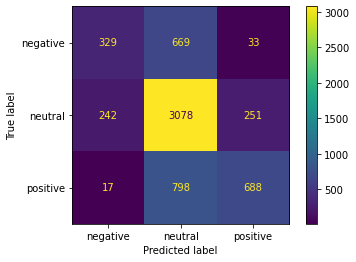

In [146]:
t0 = time.time()
S_final = clf2.fit(x_train_chi_S, y_train)
t1 = time.time()-t0
print("Excution time of logtistic regression classifier: {} s". format(round(t1,3)))

y_train_predicted = S_final.predict(x_train_chi_LR)
print("training accuracy ", np.mean(y_train_predicted == y_train))
S_final_acc = np.mean(cross_val_score(S_final,x_test_chi_S,y_valid,cv = 5))
print('validation accuracy: ' ,S_final_acc)
y_predicted = S_final.predict(x_test_chi_S)
print('prediction accuracy: ',S_final.score(x_test_chi_S, y_valid))

y_pred_S = S_final.predict(x_test_chi_S)
M_precision_S = precision_score(y_valid, y_pred_S, average="macro")
print('Macro Precision: %f ' % M_precision_S)
M_recall_S = recall_score(y_valid, y_pred_S, average="macro")
print('Macro Recall: %f ' % M_recall_S)
M_f1_S = f1_score(y_valid, y_pred_S, average="macro")
print('Macro F1 score: %f ' % M_f1_S)

W_precision_S = precision_score(y_valid, y_pred_S, average="weighted")
print('Weighted Precision: %f ' % W_precision_S)
W_recall_S = recall_score(y_valid, y_pred_S, average="weighted")
print('Weighted Recall: %f ' % W_recall_S)
W_f1_S = f1_score(y_valid, y_pred_S, average="weighted")
print('Weighted F1 score: %f ' % W_f1_S)

cm = confusion_matrix(y_valid, y_pred_S, labels = S_final.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = S_final.classes_ )
disp.plot()
